Copyright 2025 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title License
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Calculating Distinct User Logins over different months

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/bigquery-utils/blob/master/notebooks/bigquery_theta_sketches_demo.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fbigquery-utils%2Fmaster%2Fnotebooks%2bigquery_theta_sketches_demo.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/bigquery/import?url=https://github.com/GoogleCloudPlatform/bigquery-utils/blob/master/notebooks/bigquery_theta_sketches_demo.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/bigquery/v1/32px.svg" alt="BigQuery Studio logo"><br> Open in BigQuery Studio
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/bigquery-utils/blob/master/notebooks/bigquery_theta_sketches_demo.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>    

<div style="clear: both;"></div>

| | |
|-|-|
| Author |  [Nikunj Bhartia](https://github.com/nikunjbhartia)

# Demo Overview
- Data prep
- Theta Sketch Creation
   - Using BQ JS UDAF
   - The JS UD(A)Fs are loaded with OSS Datasketch Theta sketch cpp library compiled to webassembly and published in all regional BQ public datasets
- Extracting distinct users for different combinations of months:
  1. Exact using `DISTINCT`
  2. Approx, with sketch support, using BQ JS UDAF

- Compare Results
- Compare query stats


# Setup

In [ ]:
#@title Provide Google Credentials to Colab Runtime (May Require Manually Copy/Pasting Authentication Code)
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
#@title Enter Google Cloud/BigQuery Project ID for demo
project_id = '' #@param{type:"string"}

# Package used for interfacing w/ BigQuery from Python
from google.cloud import bigquery

# Create BigQuery client
bq_client = bigquery.Client(project = project_id)

In [ ]:
#@title Function to plot venn diagrams for metric extraction query results
import pandas as pd
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt

# Function to plot Venn diagram(s)
def plot_venn_diagram(df1, title_suffix1, df2=None, title_suffix2=None, base_title="Unique Users Across Jan-Mar"):
    """
    Plots a single Venn diagram if only df1 and title_suffix1 are provided.
    Plots two side-by-side Venn diagrams if df1, title_suffix1, df2, and title_suffix2 are provided.

    Parameters:
    - df1: First DataFrame with columns ['only_jan', 'only_feb', 'jan_feb', 'only_mar', 'jan_mar', 'feb_mar', 'jan_feb_mar']
    - title_suffix1: Title suffix for the first diagram (e.g., "Exact")
    - df2: Second DataFrame (optional), same schema as df1
    - title_suffix2: Title suffix for the second diagram (e.g., "Approx") (required if df2 is provided)
    - base_title: Base title for the diagram(s)
    """
    # Validate schema for df1
    expected_columns = ['only_jan', 'only_feb', 'jan_feb', 'only_mar', 'jan_mar', 'feb_mar', 'jan_feb_mar']
    if not all(col in df1.columns for col in expected_columns):
        raise ValueError("df1 must contain the columns: " + ", ".join(expected_columns))

    # Extract values for the first DataFrame
    values1 = {
        'only_jan': df1['only_jan'][0],
        'only_feb': df1['only_feb'][0],
        'jan_feb': df1['jan_feb'][0],
        'only_mar': df1['only_mar'][0],
        'jan_mar': df1['jan_mar'][0],
        'feb_mar': df1['feb_mar'][0],
        'jan_feb_mar': df1['jan_feb_mar'][0]
    }

    if df2 is None and title_suffix2 is None:
        # Single plot for one DataFrame
        plt.figure(figsize=(8, 8))
        venn = venn3(
            subsets=(values1['only_jan'], values1['only_feb'], values1['jan_feb'],
                     values1['only_mar'], values1['jan_mar'], values1['feb_mar'],
                     values1['jan_feb_mar']),
            set_labels=('January', 'February', 'March')
        )
        venn3_circles(
            subsets=(values1['only_jan'], values1['only_feb'], values1['jan_feb'],
                     values1['only_mar'], values1['jan_mar'], values1['feb_mar'],
                     values1['jan_feb_mar']),
            linestyle='dashed', linewidth=1
        )
        plt.title(f"{base_title} ({title_suffix1})")
        plt.show()
    elif df2 is not None and title_suffix2 is not None:
        # Validate schema for df2
        if not all(col in df2.columns for col in expected_columns):
            raise ValueError("df2 must contain the columns: " + ", ".join(expected_columns))

        # Extract values for the second DataFrame
        values2 = {
            'only_jan': df2['only_jan'][0],
            'only_feb': df2['only_feb'][0],
            'jan_feb': df2['jan_feb'][0],
            'only_mar': df2['only_mar'][0],
            'jan_mar': df2['jan_mar'][0],
            'feb_mar': df2['feb_mar'][0],
            'jan_feb_mar': df2['jan_feb_mar'][0]
        }

        # Side-by-side plots for two DataFrames
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

        # First DataFrame
        venn1 = venn3(
            subsets=(values1['only_jan'], values1['only_feb'], values1['jan_feb'],
                     values1['only_mar'], values1['jan_mar'], values1['feb_mar'],
                     values1['jan_feb_mar']),
            set_labels=('January', 'February', 'March'),
            ax=ax1
        )
        venn3_circles(
            subsets=(values1['only_jan'], values1['only_feb'], values1['jan_feb'],
                     values1['only_mar'], values1['jan_mar'], values1['feb_mar'],
                     values1['jan_feb_mar']),
            linestyle='dashed', linewidth=1, ax=ax1
        )
        ax1.set_title(f"{base_title} ({title_suffix1})")

        # Second DataFrame
        venn2 = venn3(
            subsets=(values2['only_jan'], values2['only_feb'], values2['jan_feb'],
                     values2['only_mar'], values2['jan_mar'], values2['feb_mar'],
                     values2['jan_feb_mar']),
            set_labels=('January', 'February', 'March'),
            ax=ax2
        )
        venn3_circles(
            subsets=(values2['only_jan'], values2['only_feb'], values2['jan_feb'],
                     values2['only_mar'], values2['jan_mar'], values2['feb_mar'],
                     values2['jan_feb_mar']),
            linestyle='dashed', linewidth=1, ax=ax2
        )
        ax2.set_title(f"{base_title} ({title_suffix2})")

        # Adjust layout
        plt.tight_layout()
        plt.show()
    else:
        raise ValueError("If df2 is provided, title_suffix2 must also be provided, and vice versa")

In [ ]:
#@title Function to plot query stats comparision charts
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

def plot_query_metrics(df, prefix_list):
    # Filter dataframe based on query_tag prefixes
    filtered_df = df[df['query_tag'].str.startswith(tuple(prefix_list))]

    # Create figure with 3 subplots in a single row
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))  # Increased width to stretch horizontally

    # Define bar width and positions
    bar_width = 0.5  # Width of each bar
    bar_positions = np.arange(len(filtered_df['query_tag']))  # Positions for bars (e.g., [0, 1])

    # Dynamically generate color_map based on prefix_list
    # Use a color palette (e.g., tab10 has 10 distinct colors)
    # https://matplotlib.org/stable/users/explain/colors/colormaps.html#qualitative
    color_palette = plt.cm.tab10(np.linspace(0, 1, len(prefix_list)))  # Generate colors for each prefix
    color_map = {prefix: color_palette[i] for i, prefix in enumerate(prefix_list)}

    # Create colors list using prefix match
    colors = [color_map[next(key for key in color_map.keys() if tag.startswith(key))]
              for tag in filtered_df['query_tag']]

    # Plot 1: Total Slot Seconds
    bars1 = ax1.bar(bar_positions, filtered_df['total_slot_sec'], color=colors, width=bar_width,
                    label=filtered_df['query_tag'])  # Add labels for legend
    ax1.set_yscale('log')  # Use logarithmic scale for y-axis
    ax1.set_title('Total Slot Seconds by Query Tag')
    ax1.set_ylabel('Slot Seconds')
    ax1.set_xticks([])  # Remove x-axis ticks
    ax1.set_xticklabels([])  # Remove x-axis labels
    ax1.grid(True, alpha=0.3, which="both")  # Grid for both major and minor ticks on log scale
    # Add exact values on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2, height * 1.1,  # 1.1 for slight offset above bar
                 f'{height:.2f}', ha='center', va='bottom')
    # Increase y-axis limit to create space for text
    max_slot_sec = max(filtered_df['total_slot_sec'])
    ax1.set_ylim(top=max_slot_sec * 2)  # Double the max value to create headroom

    # Plot 2: Total Execution Time in Seconds
    bars2 = ax2.bar(bar_positions, filtered_df['total_time_sec'], color=colors, width=bar_width,
                    label=filtered_df['query_tag'])  # Add labels for legend
    ax2.set_yscale('log')  # Use logarithmic scale for y-axis
    ax2.set_title('Total Execution Time by Query Tag')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_xticks([])  # Remove x-axis ticks
    ax2.set_xticklabels([])  # Remove x-axis labels
    ax2.grid(True, alpha=0.3, which="both")  # Grid for both major and minor ticks on log scale
    # Add exact values on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2, height * 1.1,  # 1.1 for slight offset above bar
                 f'{height:.2f}', ha='center', va='bottom')
    # Increase y-axis limit to create space for text
    max_time_sec = max(filtered_df['total_time_sec'])
    ax2.set_ylim(top=max_time_sec * 2)  # Double the max value to create headroom

    # Plot 3: Total MB Processed
    bars3 = ax3.bar(bar_positions, filtered_df['total_MB_processed'], color=colors, width=bar_width,
                    label=filtered_df['query_tag'])  # Add labels for legend
    ax3.set_yscale('log')  # Use logarithmic scale for y-axis
    ax3.set_title('Total MB Processed by Query Tag')
    ax3.set_ylabel('MB Processed')
    ax3.set_xticks([])  # Remove x-axis ticks
    ax3.set_xticklabels([])  # Remove x-axis labels
    ax3.grid(True, alpha=0.3, which="both")  # Grid for both major and minor ticks on log scale
    # Add exact values on bars
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width() / 2, height * 1.1,  # 1.1 for slight offset above bar
                 f'{height:.2f}', ha='center', va='bottom')
    # Increase y-axis limit to create space for text
    max_mb_processed = max(filtered_df['total_MB_processed'])
    ax3.set_ylim(top=max_mb_processed * 2)  # Double the max value to create headroom

    # Add a single legend for the entire figure with increased font size
    legend_font = FontProperties(size=12)  # Increase legend font size to 12
    fig.legend(bars1, filtered_df['query_tag'], loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.05),
               prop=legend_font)

    # Adjust layout to center-align charts and reduce uneven white space
    plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.02, wspace=0.3)
    # left=0.05 and right=0.95 ensure the charts stretch to nearly the full width
    # top=0.85 and bottom=0.02 reduce excess space at the top and accommodate the legend
    # wspace=0.3 maintains the spacing between subplots

    # Display the plots
    plt.show()

# Data Prep

In [ ]:
# Creating demo dataset in given project
output_dataset_id = 'datasketch_demo_us'
dataset_location = 'us'

# Combine project and dataset
dataset_id = f"{bq_client.project}.{output_dataset_id}"
dataset = bigquery.Dataset(dataset_id)
dataset.location = dataset_location

# Check to make sure output dataset exists, create it if not
try:
  bq_client.get_dataset(dataset_id)
  print(f"BigQuery dataset {dataset_id} exists\n")

except:
  print(f"BigQuery dataset {dataset_id} doesn't exist, so creating it\n")
  dataset = bq_client.create_dataset(dataset)
  print(f"BigQuery dataset {dataset_id} created in {dataset_location}")

BigQuery dataset nikunjbhartia-test-clients.datasketch_demo_us exists



## Creating sample dataset
This creates sample data for user logins spread across 3 months Jan, Feb, March

Note:
- You can decrease the `target_records` in script below for faster runtime
- But you see real benefits of sketch function based approximation at large volume


In [ ]:
%%bigquery --project {project_id}

DECLARE target_records INT64 DEFAULT 500000000;  -- 500M : Set exact number of records here

-- Generate all login events and store in a  table
CREATE OR REPLACE TABLE datasketch_demo_us.ecommerce_login_logs AS
WITH config AS (
  SELECT
    target_records,
    CAST(FLOOR(target_records / 100) AS INT64) AS base_users,
    100 AS max_events,
    CAST(CEIL(CAST(FLOOR(target_records / 100) AS FLOAT64) / 1000000) AS INT64) AS user_chunks
),
user_chunks AS (
  SELECT
    chunk_num * 1000000 + offset AS user_id
  FROM config,
  UNNEST(GENERATE_ARRAY(0, user_chunks - 1)) AS chunk_num
  CROSS JOIN UNNEST(GENERATE_ARRAY(1, 1000000)) AS offset
  # WHERE chunk_num * 1000000 + offset <= base_users
),
sample_users AS (
  SELECT
    user_id,
    CASE
      WHEN r < 0.7 THEN 1  -- 70% chance of 1 month
      WHEN r < 0.9 THEN 2  -- 20% chance of 2 months (0.9 - 0.7)
      ELSE 3               -- 10% chance of 3 months (1 - 0.9)
    END AS num_months
  FROM (
    SELECT
      user_id,
      RAND() as r
    FROM user_chunks
  )
),
user_months AS (
  SELECT
    user_id,
    CASE num_months
      WHEN 1 THEN ARRAY<INT64>[CAST(1 + FLOOR(RAND() * 3) AS INT64)]  -- 1 random month
      WHEN 2 THEN
        CASE FLOOR(RAND() * 3)  -- 2 random months
          WHEN 0 THEN ARRAY<INT64>[1, 2]  -- Jan+Feb
          WHEN 1 THEN ARRAY<INT64>[1, 3]  -- Jan+Mar
          ELSE ARRAY<INT64>[2, 3]         -- Feb+Mar
        END
      ELSE ARRAY<INT64>[1, 2, 3]  -- All 3 months
    END AS active_months,
    c.max_events AS event_count
  FROM sample_users
  JOIN config c ON TRUE
),
events_with_month AS (
  SELECT
    user_id,
    -- Distribute events evenly across active months
    active_months[OFFSET(MOD(event_num - 1, ARRAY_LENGTH(active_months)))] AS event_month,
  FROM user_months u
  CROSS JOIN UNNEST(GENERATE_ARRAY(1, event_count)) AS event_num
)
SELECT
  u.user_id,
  -- Generate event_time within the chosen month
  TIMESTAMP_ADD(
    CASE event_month
      WHEN 1 THEN TIMESTAMP('2025-01-01')  -- Jan 1
      WHEN 2 THEN TIMESTAMP('2025-02-01')  -- Feb 1
      WHEN 3 THEN TIMESTAMP('2025-03-01')  -- Mar 1
    END,
    INTERVAL
      CAST(RAND() * 28 * 24 * 60 * 60 AS INT64)
      SECOND
  ) AS event_time,
FROM events_with_month u;

Query is running:   0%|          |

""


In [ ]:
#@title Sample Data preview
%%bigquery --project {project_id}
SELECT *
FROM datasketch_demo_us.ecommerce_login_logs
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,user_id,event_time
0,297,2025-02-03 00:36:27+00:00
1,1036,2025-02-14 15:01:30+00:00
2,1282,2025-03-24 13:19:14+00:00
3,1525,2025-03-23 16:42:49+00:00
4,1578,2025-01-06 18:47:34+00:00
5,1982,2025-02-10 04:34:49+00:00
6,3530,2025-02-15 12:17:27+00:00
7,3952,2025-03-27 07:27:17+00:00
8,4516,2025-01-03 01:00:23+00:00
9,4602,2025-02-04 00:20:30+00:00


In [ ]:
#@title Sample data number of records
%%bigquery --project {project_id}
-- Verify the row count.
SELECT COUNT(*) AS row_count FROM datasketch_demo_us.ecommerce_login_logs;

Query is running:   0%|          |

Downloading:   0%|          |

,row_count
0,500000000


In [ ]:
#@title Sample data distribution across the 3 months - Jan / Feb / March
%%bigquery --project {project_id}
-- Verify the row count.
SELECT EXTRACT(MONTH FROM event_time) as event_month, COUNT(*) AS row_count
FROM datasketch_demo_us.ecommerce_login_logs
GROUP by event_month;

Query is running:   0%|          |

Downloading:   0%|          |

,event_month,row_count
0,2,166574380
1,1,166944022
2,3,166481598


# Exact Metric Extraction

In [ ]:
#@title Query to extract distinct user logins in each month combination using `DISTINCT`
%%bigquery exact_venn_stats_df --project {project_id}
/* QUERY_TAG<(01) EXACT using DISTINCT > */
WITH month_users AS (
  SELECT DISTINCT
    user_id,
    EXTRACT(MONTH FROM event_time) AS month
  FROM `datasketch_demo_us.ecommerce_login_logs`
),
user_months AS (
  SELECT
    user_id,
    STRING_AGG(CAST(month AS STRING), '' ORDER BY month) AS month_combo
  FROM month_users
  WHERE month IN (1, 2, 3)
  GROUP BY user_id
),
combinations AS (
  SELECT
    month_combo,
    COUNT(DISTINCT user_id) AS user_count
  FROM user_months
  GROUP BY month_combo
),
venn_regions AS (
  SELECT
    COALESCE(SUM(CASE WHEN month_combo = '1' THEN user_count ELSE 0 END), 0) AS only_jan,
    COALESCE(SUM(CASE WHEN month_combo = '2' THEN user_count ELSE 0 END), 0) AS only_feb,
    COALESCE(SUM(CASE WHEN month_combo = '3' THEN user_count ELSE 0 END), 0) AS only_mar,
    COALESCE(SUM(CASE WHEN month_combo = '12' THEN user_count ELSE 0 END), 0) AS jan_feb,
    COALESCE(SUM(CASE WHEN month_combo = '13' THEN user_count ELSE 0 END), 0) AS jan_mar,
    COALESCE(SUM(CASE WHEN month_combo = '23' THEN user_count ELSE 0 END), 0) AS feb_mar,
    COALESCE(SUM(CASE WHEN month_combo = '123' THEN user_count ELSE 0 END), 0) AS jan_feb_mar
  FROM combinations
)
SELECT
  only_jan,
  only_feb,
  jan_feb,
  only_mar,
  jan_mar,
  feb_mar,
  jan_feb_mar
FROM venn_regions;

Query is running:   0%|          |

Downloading:   0%|          |

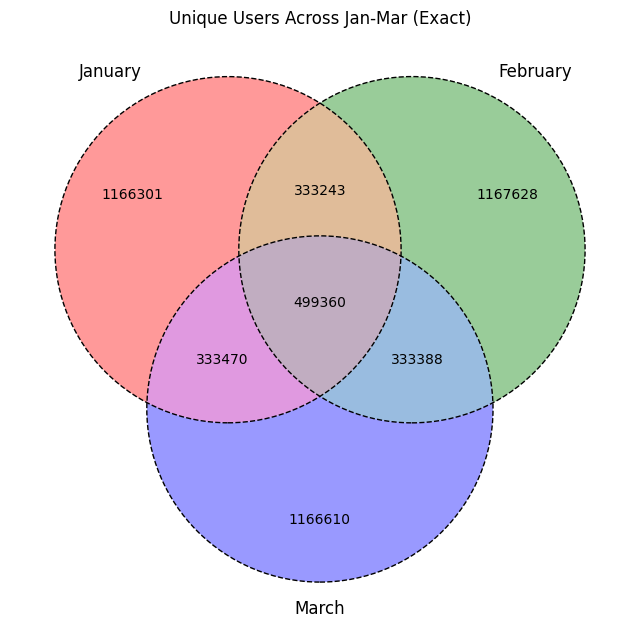

In [ ]:
plot_venn_diagram(exact_venn_stats_df, title_suffix1="Exact")

# Theta Sketch Creation


### OSS Theta Sketch Creation using BQ JS UDAF

[datasketches-bigquery github](https://github.com/apache/datasketches-bigquery/tree/main/theta)

[theta sketch relative error](https://datasketches.apache.org/docs/Theta/ThetaErrorTable.html)

Note: BigQuery also has cardinality estimation native sketch functions called [HLL++](https://cloud.google.com/bigquery/docs/reference/standard-sql/hll_functions) sketches but they don't support intersection or difference sketch operations unlike the theta sketch BQ UD(A)Fs

In [ ]:
#@title Query to create day based theta sketches for entire dataset
%%bigquery --project {project_id}
/* QUERY_TAG<(03) CREATE_THETA_SKETCHES_ALL> */
CREATE OR REPLACE TABLE `datasketch_demo_us.theta_sketches_per_day`
PARTITION BY event_date AS
SELECT
  DATE(event_time) as event_date,
  bqutil.datasketches.theta_sketch_agg_int64(user_id) as users_theta_sketch
FROM `datasketch_demo_us.ecommerce_login_logs`
GROUP BY event_date

Query is running:   0%|          |

""


In [ ]:
#@title Query to create theta sketche for one day
# This query is used only for stats comparision because ideally this is what users would use for incremental sketch creation
# Would also help amortize overall compute with sketch extraction queries
%%bigquery --project {project_id}
/* QUERY_TAG<(04) CREATE_THETA_SKETCHES_1Day> */
SELECT
  DATE(event_time) as event_date,
  bqutil.datasketches.theta_sketch_agg_int64(user_id) as users_theta_sketch
FROM `datasketch_demo_us.ecommerce_login_logs`
WHERE DATE(event_time) = "2025-01-01"
GROUP BY event_date

Query is running:   0%|          |

Downloading:   0%|          |

,event_date,users_theta_sketch
0,2025-01-01,b'\x02\x04\x03-\x02\x1a\xcc\x93\xa4\x85\xb1\x0...


In [ ]:
# Sample output of sketches table
%%bigquery --project {project_id}
SELECT *
from `datasketch_demo_us.theta_sketches_per_day`
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,event_date,users_theta_sketch
0,2025-02-19,b'\x02\x04\x03.\x02\x1a\xcc\x93s\xebBx\xdf\xa6...
1,2025-01-18,"b'\x02\x04\x03.\x02\x1a\xcc\x93,\xbb\xc7L\x84\..."
2,2025-02-05,b'\x02\x04\x03.\x02\x1a\xcc\x93\x8c\xd9\xb1so\...
3,2025-02-25,b'\x02\x04\x03.\x02\x1a\xcc\x93\xee\xfey\x86\x...
4,2025-01-04,b'\x02\x04\x03.\x02\x1a\xcc\x93ubJ\x88\xf94B\x...
5,2025-03-26,b'\x02\x04\x03-\x02\x1a\xcc\x93\xc6\x81\x9a\xe...
6,2025-01-28,b'\x02\x04\x03.\x02\x1a\xcc\x93\xb6\xef\\M*\x9...
7,2025-03-06,b'\x02\x04\x03.\x02\x1a\xcc\x93U)\x1e|H\xbb@\x...
8,2025-03-03,b'\x02\x04\x03.\x02\x1a\xcc\x93\x8c\xd9\xb1so\...
9,2025-03-02,b'\x02\x04\x03-\x02\x1a\xcc\x93\xd6\x871\xb4\x...


# Approx Metric Extraction

See all supported theta sketch functions in [datasketches-bigquery repo](https://github.com/apache/datasketches-bigquery/tree/main/theta)

- All these functions are published in all regional BQ public datasets : `bqutil.datasketches` (US multiregion) or `bqutil.datasketches_<region>`
- See [bigquery-utils repo](https://github.com/GoogleCloudPlatform/bigquery-utils/tree/master/udfs#repo-folder-to-bigquery-dataset-mappings) for more details

In [ ]:
#@title Query to extract distinct user logins in each month combination using theta sketch BQ UD(A)Fs
%%bigquery approx_venn_stats_df --project {project_id}

/* QUERY_TAG<(02) APPROX using THETA_SKETCHES > */
WITH monthly_sketches AS (
  -- Union daily sketches into monthly sketches
  SELECT
    EXTRACT(MONTH FROM event_date) AS month,
    bqutil.datasketches.theta_sketch_agg_union(users_theta_sketch) AS month_sketch
  FROM `datasketch_demo_us.theta_sketches_per_day`
  WHERE event_date BETWEEN '2025-01-01' AND '2025-03-31'
  GROUP BY month
),
month_sketches AS (
  -- Pivot to get individual month sketches
  SELECT
    MAX(CASE WHEN month = 1 THEN month_sketch END) AS jan_sketch,
    MAX(CASE WHEN month = 2 THEN month_sketch END) AS feb_sketch,
    MAX(CASE WHEN month = 3 THEN month_sketch END) AS mar_sketch
  FROM monthly_sketches
),
venn_sketches AS (
  -- Compute sketches for all 7 Venn regions
  SELECT
    -- Only Jan: Jan - (Feb ∪ Mar)
    bqutil.datasketches.theta_sketch_a_not_b(
      jan_sketch,
      bqutil.datasketches.theta_sketch_union(feb_sketch, mar_sketch)
    ) AS only_jan_sketch,
    -- Only Feb: Feb - (Jan ∪ Mar)
    bqutil.datasketches.theta_sketch_a_not_b(
      feb_sketch,
      bqutil.datasketches.theta_sketch_union(jan_sketch, mar_sketch)
    ) AS only_feb_sketch,
    -- Only Mar: Mar - (Jan ∪ Feb)
    bqutil.datasketches.theta_sketch_a_not_b(
      mar_sketch,
      bqutil.datasketches.theta_sketch_union(jan_sketch, feb_sketch)
    ) AS only_mar_sketch,
    -- Jan ∩ Feb (no Mar): (Jan ∩ Feb) - Mar
    bqutil.datasketches.theta_sketch_a_not_b(
      bqutil.datasketches.theta_sketch_intersection(jan_sketch, feb_sketch),
      mar_sketch
    ) AS jan_feb_sketch,
    -- Jan ∩ Mar (no Feb): (Jan ∩ Mar) - Feb
    bqutil.datasketches.theta_sketch_a_not_b(
      bqutil.datasketches.theta_sketch_intersection(jan_sketch, mar_sketch),
      feb_sketch
    ) AS jan_mar_sketch,
    -- Feb ∩ Mar (no Jan): (Feb ∩ Mar) - Jan
    bqutil.datasketches.theta_sketch_a_not_b(
      bqutil.datasketches.theta_sketch_intersection(feb_sketch, mar_sketch),
      jan_sketch
    ) AS feb_mar_sketch,
    -- Jan ∩ Feb ∩ Mar
    bqutil.datasketches.theta_sketch_intersection(
      bqutil.datasketches.theta_sketch_intersection(jan_sketch, feb_sketch),
      mar_sketch
    ) AS jan_feb_mar_sketch
  FROM month_sketches
)
SELECT
  -- Extract estimates and bounds for each region
  CAST(bqutil.datasketches.theta_sketch_get_estimate(only_jan_sketch) AS INT64) AS only_jan,
  CAST(bqutil.datasketches.theta_sketch_get_estimate(only_feb_sketch) AS INT64) AS only_feb,
  CAST(bqutil.datasketches.theta_sketch_get_estimate(jan_feb_sketch) AS INT64) AS jan_feb,
  CAST(bqutil.datasketches.theta_sketch_get_estimate(only_mar_sketch) AS INT64) AS only_mar,
  CAST(bqutil.datasketches.theta_sketch_get_estimate(jan_mar_sketch) AS INT64) AS jan_mar,
  CAST(bqutil.datasketches.theta_sketch_get_estimate(feb_mar_sketch) AS INT64) AS feb_mar,
  CAST(bqutil.datasketches.theta_sketch_get_estimate(jan_feb_mar_sketch)  AS INT64) AS jan_feb_mar
FROM venn_sketches;

Query is running:   0%|          |

Downloading:   0%|          |

# Comparing results

In [ ]:
approx_venn_stats_df

,only_jan,only_feb,jan_feb,only_mar,jan_mar,feb_mar,jan_feb_mar
0,1137932,1199846,346590,1219656,315345,345432,491822


In [ ]:
exact_venn_stats_df

,only_jan,only_feb,jan_feb,only_mar,jan_mar,feb_mar,jan_feb_mar
0,1166301,1167628,333243,1166610,333470,333388,499360


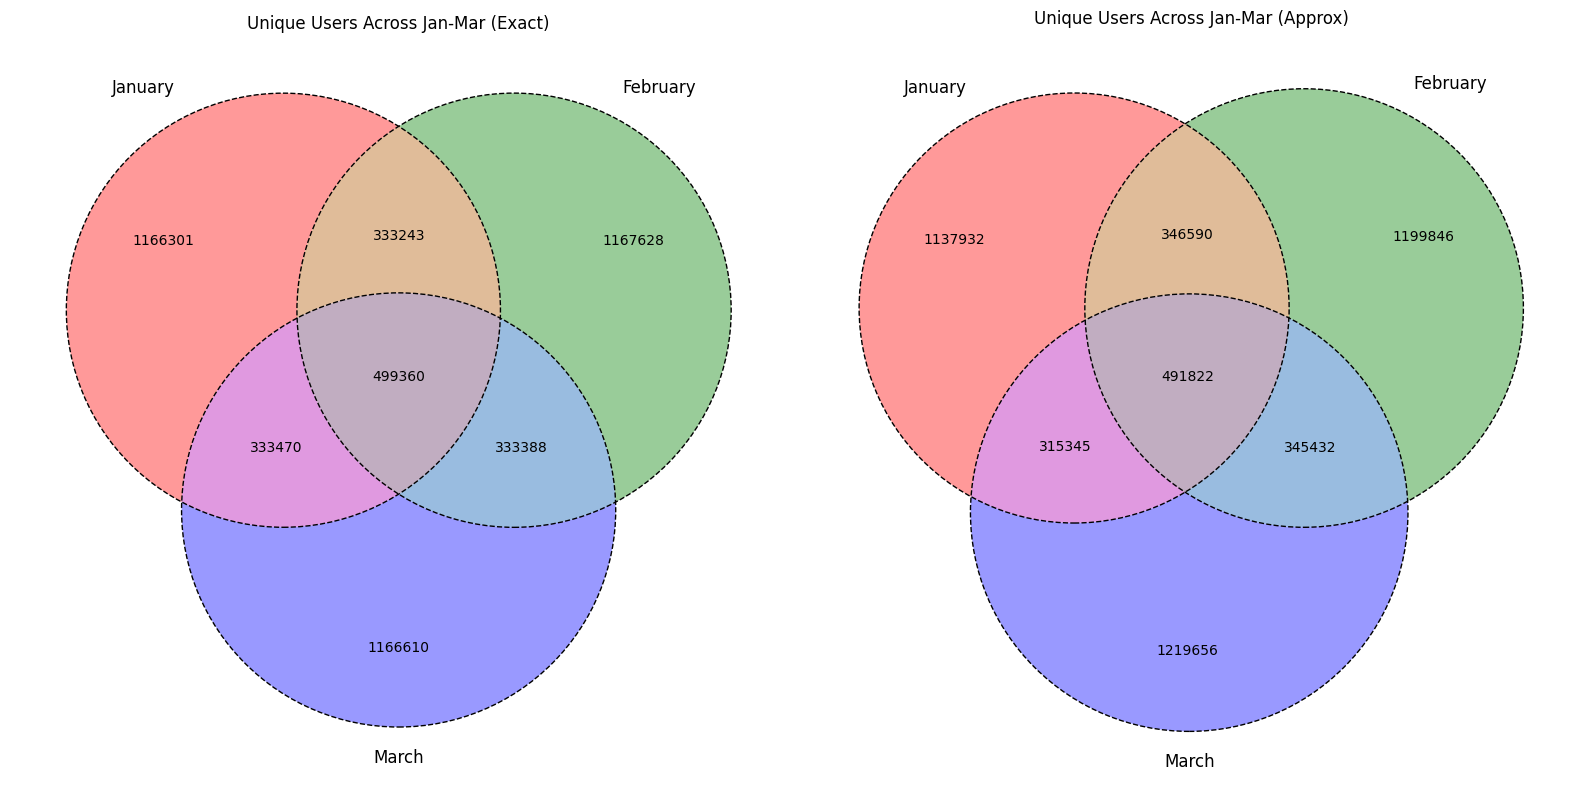

In [ ]:
#@title Venn diagram representing results from both exact and approx methods
plot_venn_diagram(exact_venn_stats_df, "Exact", approx_venn_stats_df, "Approx")

# Comparing Query Stats

This compares query stats like slot_sec, total query runtime, memory scanned etc for all the relevant queries above identified by query tags embedded in each sql query.

In [ ]:
%%bigquery stats_df --project {project_id}
DECLARE CURRENT_DT DATE DEFAULT CURRENT_DATE();

SELECT
  query_tag,
  total_time_sec,
  total_slot_sec,
  ROUND(LAG(total_slot_sec, 1, 1) OVER( ORDER BY query_tag ASC ) / total_slot_sec, 1) as slot_sec_prev_vs_curr,
  total_MB_processed,
  ROUND(LAG(total_MB_processed, 1, 1) OVER( ORDER BY query_tag ASC ) / total_MB_processed, 1) as total_MB_prev_vs_curr,
  shuffle_output_MB,
  cache_hit,
  creation_time
FROM (
  SELECT *
  FROM (
    SELECT
      REGEXP_EXTRACT(query, r'/\* QUERY_TAG<(.*?)> \*/') AS query_tag,
      (TIMESTAMP_DIFF(end_time, start_time, MILLISECOND)/1000) as total_time_sec,
      (total_slot_ms/1000) as total_slot_sec,
      (total_bytes_processed/pow(1024,2)) AS total_MB_processed,
      (SELECT SUM(stage.shuffle_output_bytes) FROM UNNEST(job_stages) stage)/pow(1024,2) AS shuffle_output_MB,
      cache_hit,
      creation_time
    FROM `region-us`.INFORMATION_SCHEMA.JOBS_BY_PROJECT
    WHERE state='DONE'
    AND DATE(creation_time) = CURRENT_DT
    AND creation_time BETWEEN TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 10 MINUTE) AND CURRENT_TIMESTAMP()
    AND query LIKE "%QUERY_TAG%")
  WHERE query_tag IS NOT NULL
  QUALIFY ROW_NUMBER() OVER (PARTITION BY query_tag ORDER BY creation_time DESC) = 1)
ORDER BY query_tag ASC;


Query is running:   0%|          |

Downloading:   0%|          |

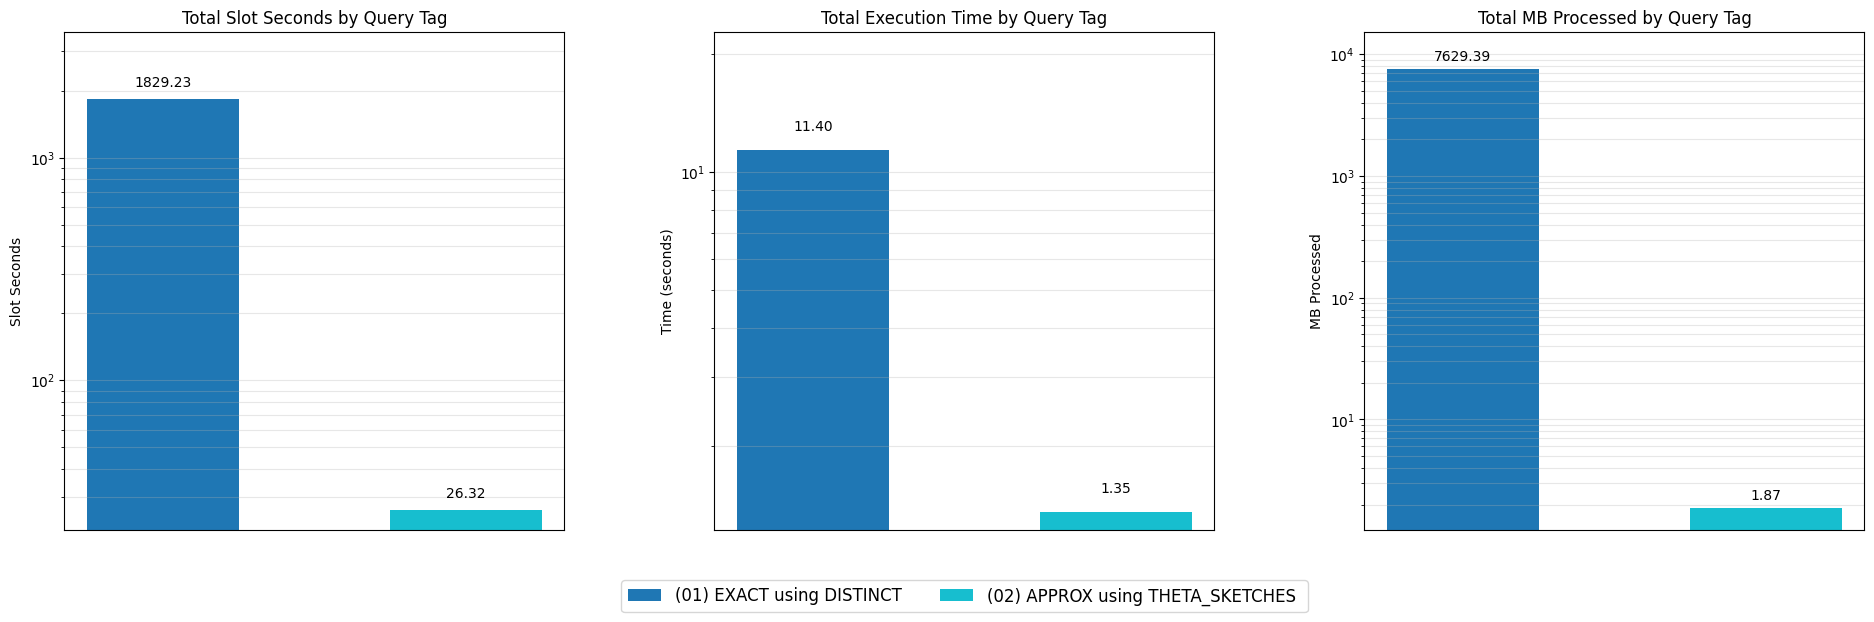

In [ ]:
#@title Plot charts for comparing exact and approx methods
prefix_list = ['(01)', '(02)']
plot_query_metrics(stats_df, prefix_list)

In [ ]:
#@title All query stats also includes sketch creation stats for historic and incremental sketch creation
stats_df

,query_tag,total_time_sec,total_slot_sec,slot_sec_prev_vs_curr,total_MB_processed,total_MB_prev_vs_curr,shuffle_output_MB,cache_hit,creation_time
0,(01) EXACT using DISTINCT,11.397,1829.231,0.0,7629.394531,0.0,8488.357736,False,2025-03-13 08:47:28.135000+00:00
1,(02) APPROX using THETA_SKETCHES,1.355,26.319,69.5,1.869932,4080.0,1.940579,False,2025-03-13 08:48:06.623000+00:00
2,(03) CREATE_THETA_SKETCHES_ALL,10.876,2242.430,0.0,7629.394531,0.0,1898.038181,False,2025-03-13 08:47:47.038000+00:00
3,(04) CREATE_THETA_SKETCHES_1Day,3.113,455.688,4.9,7629.394531,1.0,38.380662,False,2025-03-13 08:47:58.739000+00:00
